# LSTM - HOBO Sensor Sites

In this notebook, we train an LSTM model to predict dry (0) or wet (1) for a given HJ Andrews HOBO Sensor Site 3 days after a given date. The model uses features at time t and the current wet/dry status (target[t]) to predict target[t+3].

Sequences are created per site to avoid cross-site boundary contamination.

We apply ADASYN to the training data and use a random train-test split.

## Imports

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
np.random.seed(42)
torch.manual_seed(42)

## Data Preprocessing

In [12]:
# Data Paths
DRIVERS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/drivers_xgb.csv"
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load datasets
drivers = pd.read_csv(DRIVERS_PATH)
data = pd.read_parquet(OBS_PATH)
static_df = pd.read_parquet(STATIC_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

# Isolate the target variable
dfs = {val: data[data['variable'] == val] for val in data['variable'].unique()}
wet_dry_df = dfs['HoboWetDry0.05']

# Normalize types before merging
wet_dry_df = wet_dry_df.copy()
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

# Merge all datasets
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

In [ ]:
# Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

# Target: wet/dry status 3 days ahead (target[t+3])
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-3)

# Drop rows with NaN values from target
central_df = central_df.dropna(subset=['wet_dry_next'])

# Define feature columns (same as XGB/LR)
drop_cols = ['variable', 'NHDPlusID', 'SiteIDCode', 'Date', 'wet_dry_next']
feature_cols = [c for c in central_df.columns if c not in drop_cols]

# Fill NaNs in features
central_df[feature_cols] = central_df[feature_cols].ffill().bfill().fillna(0)

print(f"Dataset: {len(central_df)} samples, {len(feature_cols)} features")
print(f"Features: {feature_cols}")

Dataset: 2593 samples, 33 features
Features: ['value', 'etalfalfa', 'etgrass', 'prcp', 'rhmax', 'rhmin', 'srad', 'sph', 'tmax', 'tmin', 'vp', 'ws', 'ArbolateSu', 'AreaSqKm', 'FromNode', 'LengthKM', 'Slope', 'ToNode', 'TotDASqKm', 'aspect_ne_pct', 'aspect_nw_pct', 'aspect_se_pct', 'aspect_sw_pct', 'curv_mean', 'curv_median', 'elev_max_cm', 'elev_mean_cm', 'elev_median_cm', 'elev_min_cm', 'slp_mean_pct', 'slp_median_pct', 'In-degree', 'Out-degree']


## Model Architecture

In [14]:
SEQ_LEN = 30

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


def create_sequences_by_site(df, site_col, feature_cols, target_col, seq_len=SEQ_LEN):
    """Create sliding window sequences grouped by site to avoid cross-site contamination."""
    X, y = [], []
    for _, group in df.groupby(site_col):
        if len(group) <= seq_len:
            continue
        features = group[feature_cols].values
        labels = group[target_col].values
        for i in range(len(group) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(labels[i + seq_len - 1])
    return np.array(X), np.array(y)

## ADASYN Resampling and Model Training

In [15]:
# Scale features
scaler = StandardScaler()
central_df[feature_cols] = scaler.fit_transform(central_df[feature_cols])

# Create sequences per site (avoids cross-site boundary sequences)
X_all, y_all = create_sequences_by_site(
    central_df, 'NHDPlusID', feature_cols, 'wet_dry_next', seq_len=SEQ_LEN
)
print(f"Sequences: {X_all.shape}, Labels: {y_all.shape}")
print(f"Class distribution — Wet: {int((y_all > 0.5).sum())}, Dry: {int((y_all <= 0.5).sum())}")

# Random train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=True, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# ADASYN on training data only (flatten 3D -> 2D, resample, reshape back)
n_samples, seq_length, n_features = X_train.shape
X_flat = X_train.reshape(n_samples, seq_length * n_features)
adasyn = ADASYN(random_state=42)
X_flat_res, y_train_res = adasyn.fit_resample(X_flat, y_train.astype(int))
X_train_res = X_flat_res.reshape(-1, seq_length, n_features)
print(f"After ADASYN — Train: {X_train_res.shape}")

# Train/val split for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_res, y_train_res, test_size=0.2, random_state=42
)

# Convert to tensors
X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
y_tr_t = torch.tensor(y_tr.reshape(-1, 1), dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)

# Model
LSTM_model = LSTMModel(input_size=n_features)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0]))
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=1e-4)

# Training loop with early stopping
best_val_loss = float('inf')
best_state = None
patience_counter = 0
epochs = 15

for epoch in range(epochs):
    LSTM_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = LSTM_model(xb)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(LSTM_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    LSTM_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = LSTM_model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss={total_loss/len(train_loader):.4f} | Val Loss={val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.clone() for k, v in LSTM_model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered.")
            break

LSTM_model.load_state_dict(best_state)
print("Loaded best model state.")

Sequences: (1933, 30, 33), Labels: (1933,)
Class distribution — Wet: 1585, Dry: 348
Train: (1546, 30, 33), Test: (387, 30, 33)
After ADASYN — Train: (2528, 30, 33)
Epoch 1/15 | Train Loss=0.6803 | Val Loss=0.6578
Epoch 2/15 | Train Loss=0.6048 | Val Loss=0.4965
Epoch 3/15 | Train Loss=0.3422 | Val Loss=0.2053
Epoch 4/15 | Train Loss=0.1611 | Val Loss=0.1147
Epoch 5/15 | Train Loss=0.1094 | Val Loss=0.0901
Epoch 6/15 | Train Loss=0.0887 | Val Loss=0.0833
Epoch 7/15 | Train Loss=0.0849 | Val Loss=0.0711
Epoch 8/15 | Train Loss=0.0693 | Val Loss=0.0659
Epoch 9/15 | Train Loss=0.0787 | Val Loss=0.0660
Epoch 10/15 | Train Loss=0.0584 | Val Loss=0.0605
Epoch 11/15 | Train Loss=0.0639 | Val Loss=0.0594
Epoch 12/15 | Train Loss=0.0597 | Val Loss=0.0587
Epoch 13/15 | Train Loss=0.0513 | Val Loss=0.0559
Epoch 14/15 | Train Loss=0.0507 | Val Loss=0.0545
Epoch 15/15 | Train Loss=0.0570 | Val Loss=0.0532
Loaded best model state.


## Metrics and Feature Importance

Accuracy: 0.9767
ROC-AUC: 0.9748
F1 Score: 0.9856

              precision    recall  f1-score   support

         Dry      0.908     0.972     0.939        71
         Wet      0.994     0.978     0.986       316

    accuracy                          0.977       387
   macro avg      0.951     0.975     0.962       387
weighted avg      0.978     0.977     0.977       387



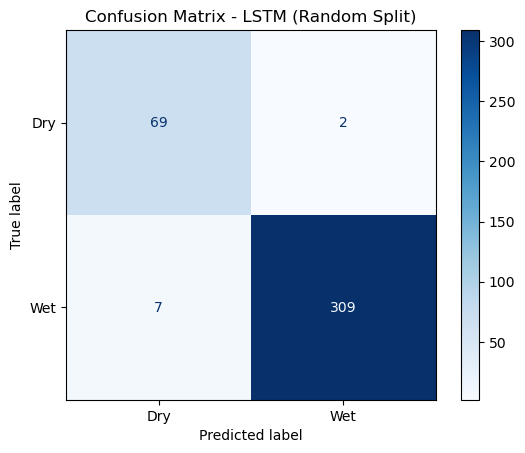

In [16]:
# Predict on test set
X_test_t = torch.tensor(X_test, dtype=torch.float32)

LSTM_model.eval()
with torch.no_grad():
    logits = LSTM_model(X_test_t).squeeze()
    logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
    y_probs = torch.sigmoid(logits).numpy()
    y_pred = (y_probs >= 0.5).astype(int)

y_true = y_test.astype(int)

accuracy = accuracy_score(y_true, y_pred)
roc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1 Score: {f1:.4f}")

print()
print(classification_report(y_true, y_pred, target_names=['Dry', 'Wet'], digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - LSTM (Random Split)")
plt.show()

       Feature  Importance
         value    0.050793
 aspect_ne_pct    0.030232
    Out-degree    0.029671
 aspect_se_pct    0.015662
           sph    0.014492
slp_median_pct    0.009723
   elev_min_cm    0.009569
 aspect_nw_pct    0.008082
          srad    0.006648
  slp_mean_pct    0.006446
 aspect_sw_pct    0.006446
          tmax    0.004939
            vp    0.004877
        ToNode    0.004694
  elev_mean_cm    0.004694
         rhmin    0.003302
    ArbolateSu    0.003246
   elev_max_cm    0.003190
elev_median_cm    0.003190
         rhmax   -0.003154
      FromNode    0.001620
            ws   -0.001575
     In-degree    0.001569
     TotDASqKm    0.001569
         Slope    0.001569
   curv_median    0.001569
     etalfalfa    0.001569
      LengthKM    0.001569
     curv_mean    0.000000
       etgrass    0.000000
      AreaSqKm    0.000000
          tmin    0.000000
          prcp    0.000000


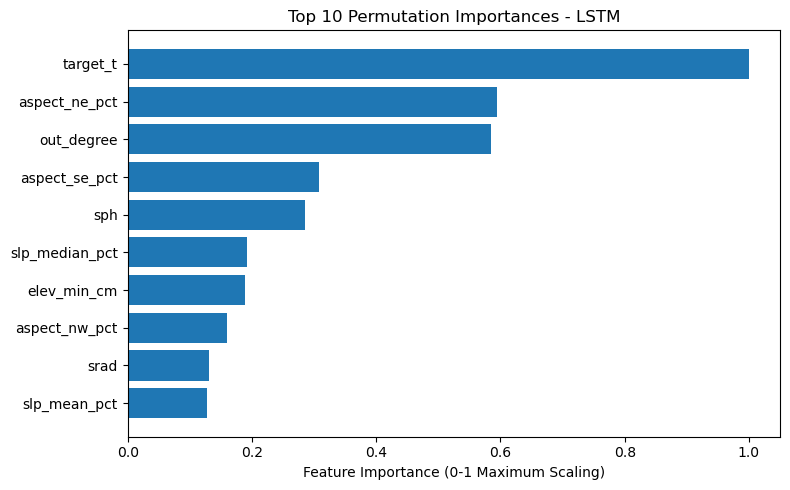

In [ ]:
# Permutation importance
LSTM_model.eval()
with torch.no_grad():
    base_probs = torch.sigmoid(LSTM_model(X_test_t).squeeze()).numpy()
base_preds = (base_probs >= 0.5).astype(int)
base_f1 = f1_score(y_true, base_preds)

importances = []
for i, col in enumerate(feature_cols):
    X_perm = X_test.copy()
    X_perm[:, :, i] = np.random.permutation(X_perm[:, :, i])
    X_perm_t = torch.tensor(X_perm, dtype=torch.float32)
    with torch.no_grad():
        perm_probs = torch.sigmoid(LSTM_model(X_perm_t).squeeze()).numpy()
    perm_preds = (perm_probs >= 0.5).astype(int)
    perm_f1 = f1_score(y_true, perm_preds)
    importances.append(base_f1 - perm_f1)

imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
imp_df['Abs_Importance'] = imp_df['Importance'].abs()
imp_df = imp_df.sort_values('Abs_Importance', ascending=False)

print(imp_df[['Feature', 'Importance']].to_string(index=False))

# Scale to 0-1 (max-normalization)
imp_df['Scaled'] = imp_df['Abs_Importance'] / imp_df['Abs_Importance'].max()

# Rename for visualization
imp_df['Feature'] = imp_df['Feature'].replace({
    'Out-degree': 'out_degree',
    'In-degree': 'in_degree',
    'value': 'lagged_target',
})

top10 = imp_df.head(10)
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Scaled'][::-1])
ax.set_xlabel('Feature Importance (0-1 Maximum Scaling)')
ax.set_title('Top 10 Permutation Importances - LSTM')
plt.tight_layout()
plt.show()